# Import packages

In [2]:
import os
import json
import torch
import torch.nn as nn
from torch.autograd import Variable, grad
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import time
import ast
import copy

# PINN class

In [7]:
class PhysicsInformedNN(nn.Module):

  def __init__(self, layer_dim_u, layer_dim_K, input_K=None, inv_params=None, num_pumps=25):
    super(PhysicsInformedNN, self).__init__()


    self.weights = []

    self.preds = None

    self.loss = 0.0

    self.loss_list = []   
    self.loss_dict = {'neum':[0.0], 'diri':[0.0],'u':[0.0],'f':[0.0],'K':[0.0],'pump':[0.0]}
    self.loss_container = []

    def block(in_feat, out_feat, normalize=False):
      layers = [nn.Linear(in_feat, out_feat)]
      if normalize:
          layers.append(nn.BatchNorm1d(out_feat, 0.8))
      # layers.append(nn.LeakyReLU(0.2, inplace=True))
      layers.append(nn.Tanh())
      return layers

    self.forward_models = []
    for i in range(num_pumps):
      self.modules = []
      for j in range(len(layer_dim_u)-2):
        input_dim, output_dim = layer_dim_u[j], layer_dim_u[j+1],
        self.modules += block(input_dim, output_dim, normalize=False)
      self.modules.append(nn.Linear(output_dim, layer_dim_u[j+2]))
      self.forward_models.append(nn.Sequential(*self.modules))


    self.modules = []
    for j in range(len(layer_dim_K)-2):
      input_dim, output_dim = layer_dim_K[j], layer_dim_K[j+1],
      self.modules += block(input_dim, output_dim, normalize=False)
    self.modules.append(nn.Linear(output_dim, layer_dim_K[j+2]))
    self.inverse_model = nn.Sequential(*self.modules)


    for i in range(num_pumps): 
      loss_dict = {'neum':[], 'diri':[],'u':[],'f':[],'K':[],'pump':[]}
      self.loss_container.append(loss_dict)


  def net_u(self, x, y, pid): # head u, including Dirichlet BCs
    H = torch.cat((x,y),1)
    u = self.forward_models[pid](H)
    return u
  
  def net_K(self, x, y): # hydraulic conductivity K

    H = torch.cat((x,y),1)
    K = self.inverse_model(H)

    return K
  

  def net_du(self, x, y, pid): # first-order derivative match, inlcuding Neumann BCs

    u = self.net_u(x, y, pid)

    u_x = grad(u.sum(), x, create_graph=True, retain_graph=True)[0]
    u_y = grad(u.sum(), y, create_graph=True)[0]

    return u_x.requires_grad_(True), u_y.requires_grad_(True)

  def net_dK(self, x, y): # first-order derivative of K
    K = self.net_K(x, y)#, self.weights_u, self.biases_u)

    K_x = grad(K.sum(), x, create_graph=True)[0]
    K_y = grad(K.sum(), y, create_graph=True)[0]

    return K_x.requires_grad_(True), K_y.requires_grad_(True)


  def net_f(self, x, y, pid): # general PDE match, usually formulated in higher-order

    u_x, u_y = self.net_du(x, y, pid)
    u_yy = grad(u_y.sum(), y, create_graph=True)[0]
    u_xx = grad(u_x.sum(), x, create_graph=True)[0]

    K = self.net_K(x, y)
    K_x, K_y = self.net_dK(x, y)

    f = K*(u_yy + u_xx) + K_x*u_x + K_y*u_y

    return f.requires_grad_(True)

  def forward(self, x_tensors, y_tensors, pid, keys=None):

    if keys is None:
      keys = x_tensors.keys()
    else:
      preds = dict()
      for i in keys:
          preds[i] = None

    for i in keys:

      if i == 'neum':
        dudx_pred, dudy_pred = self.net_du(x_tensors[i], y_tensors[i], pid)
        preds[i] = dudy_pred

      elif i == 'f':
        f_pred = self.net_f(x_tensors[i], y_tensors[i], pid)
        preds[i] = f_pred

      elif i == 'u':
        u_pred = self.net_u(x_tensors[i], y_tensors[i], pid) 
        preds[i] = u_pred
          
      elif i == 'K':
        K_pred = self.net_K(x_tensors[i], y_tensors[i])

        preds[i] = K_pred
          
      elif i == 'diri':
        diri_pred = self.net_u(x_tensors[i], y_tensors[i], pid) 
        preds[i] = diri_pred

      elif i == 'pump':
        p_pred = self.net_f(x_tensors[i], y_tensors[i], pid)
        preds[i] = p_pred

    return preds

  def loss_func(self, pred_dict, true_dict, pump_id, weights=None):
  
    loss = torch.tensor(0.0, dtype=torch.float32)
    keys = pred_dict.keys()

    if weights is None:
      weights = dict()
      for i in keys:
        weights[i] = 1.0

    for i in keys:
      res = pred_dict[i] - true_dict[i]
      loss += weights[i]*torch.mean(res.pow(2))
      r = torch.mean(res.pow(2)).item()
      self.loss_container[pump_id][i].append(r*weights[i])
    return loss.requires_grad_()


  def unzip_train_dict(self, train_dict, keys=None):
    if keys is None:
      keys = train_dict.keys()

    x_tensors = dict()
    y_tensors = dict()
    true_dict = dict()

    for i in keys:
      x_tensors[i] = train_dict[i][0]
      y_tensors[i] = train_dict[i][1]
      true_dict[i] = train_dict[i][2]

    return (x_tensors, y_tensors, true_dict)

  def train(self, iter, data_batch, loss_func, optimizer, pred_keys=None, loss_weights=None, pump_id_list=[0], print_interval=1000):
      
    if pred_keys is None:
      pred_keys= data_batch[0].keys()
    for i in range(iter):
      optimizer.zero_grad()
      loss = 0.0
      for pump_id in pump_id_list:
        train_dict = data_batch[pump_id]

        (x_tensors, y_tensors, true_dict) = self.unzip_train_dict(train_dict,pred_keys)
        pred_dict = self.forward(x_tensors, y_tensors, pump_id, keys=pred_keys)
        loss += loss_func(pred_dict, true_dict, pump_id, loss_weights)

      loss.backward()
      self.callback(loss.detach().numpy().squeeze())

      optimizer.step()


  def callback(self, loss):
    self.loss_list.append(loss)

  def coor_shift(self, X, lbs, ubs):
    return 2.0*(X - lbs) / (ubs - lbs) - 1

  def data_loader(self, X, u, lbs, ubs):
              
    X = self.coor_shift(X, lbs, ubs)

    x_tensor = torch.tensor(X[:,0:1], requires_grad=True, dtype=torch.float32)
    y_tensor = torch.tensor(X[:,1:2], requires_grad=True, dtype=torch.float32)

    u_tensor = torch.tensor(u, dtype=torch.float32)
    
    return (x_tensor, y_tensor, u_tensor)

  def predict(self, X_input, pid=0, target='u'):
    x_tensor = torch.tensor(X_input[:,0:1], dtype=torch.float32, requires_grad=True)
    y_tensor = torch.tensor(X_input[:,1:2], dtype=torch.float32, requires_grad=True)
    pred = None
    if target == 'u':
      pred = self.net_u(x_tensor, y_tensor, pid).detach().numpy().squeeze()
    elif target == 'du':
      dudx, dudy = self.net_du(x_tensor, y_tensor, pid)
      return dudx.detach().numpy().squeeze(), dudy.detach().numpy().squeeze()
    elif target == 'f':
      pred = self.net_f(x_tensor, y_tensor, pid).detach().numpy().squeeze()

    elif target == 'K':
      pred = self.net_K(x_tensor, y_tensor).detach().numpy().squeeze()

    return pred


# Load fields:
## logK
## Hydraulic heads
### 25 pumping tests


In [8]:
################ hydraulic conductivty field ###################
logK = np.loadtxt('./data/logK_field.txt')
K = np.exp(logK)
(nx,ny) = logK.shape

################ K measurement locations ###################
K_measure_id = np.loadtxt('./data/K_measure_id_61.txt').astype(int)

################ pumping well locations ###################
num_wells = 25
well_id = np.arange(num_wells)
pump_cell_idx = np.loadtxt('./data/pump_well_id_25.txt').astype(int)

################ hydraulic heads under each pumping event ###################
heads = np.empty((nx*ny, num_wells))
for i in range(num_wells):
  head = np.loadtxt('./data/heads/head_pump'+str(i)+'.txt') 
  heads[:,i]=head.T.flatten()

# Domain

In [9]:
############### define domain with (0,0) at center ######
Lox, Loy = 1, 1
dx, dy = Lox/nx, Loy/ny
x = np.arange((-Lox/2+dx/2),(Lox/2),dx)
y = np.arange((-Lox/2+dx/2),(Lox/2),dy)

X, Y = np.meshgrid(x,y)

X_star = np.hstack((X.flatten()[:,None], Y.flatten()[:,None]))

#################  relax region defination ##################
r = 48  # half-length of relax region

pump_row_idx = np.repeat(pump_cell_idx[:,None],2*r-1,1)
pump_row_idx = pump_row_idx - np.arange(-r+1,r)
around_idx = [pump_row_idx]
for i in range(1,r):
  around_idx = [pump_row_idx-nx*i] + around_idx + [nx*i+pump_row_idx]
around_idx = np.hstack(around_idx)
around_idx = np.delete(around_idx,int(((2*r-1)**2-1)/2),1)

#################  boundary cell locations ##################
id1 = np.where(X.flatten() == min(x))
id2 = np.where(X.flatten() == max(x))

id3 = np.where(Y.flatten() == min(y))
id4 = np.where(Y.flatten() == max(y))
xbound_idx = np.unique(np.hstack((id1,id2)))
ybound_idx = np.unique(np.hstack((id3,id4)))

# Show fields

/var/folders/lj/0cv5trz16fb3k479qq3q1vnw0000gn/T/ipykernel_67467/1938809779.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(labels,fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')


Text(0.5, 1.0, 'Water head of p12')

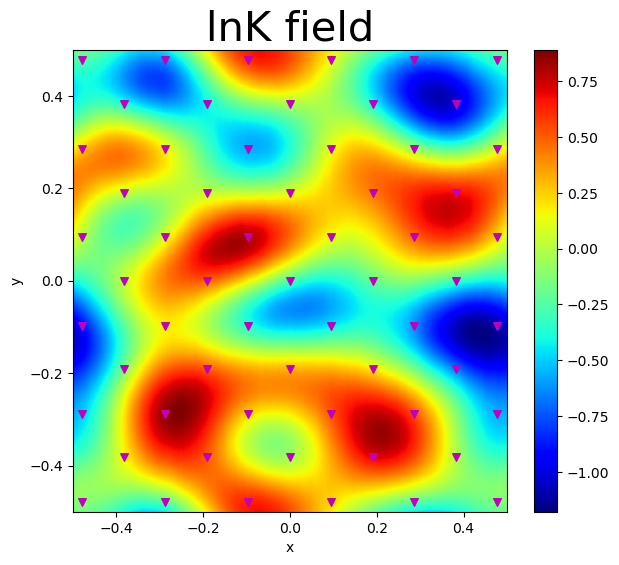

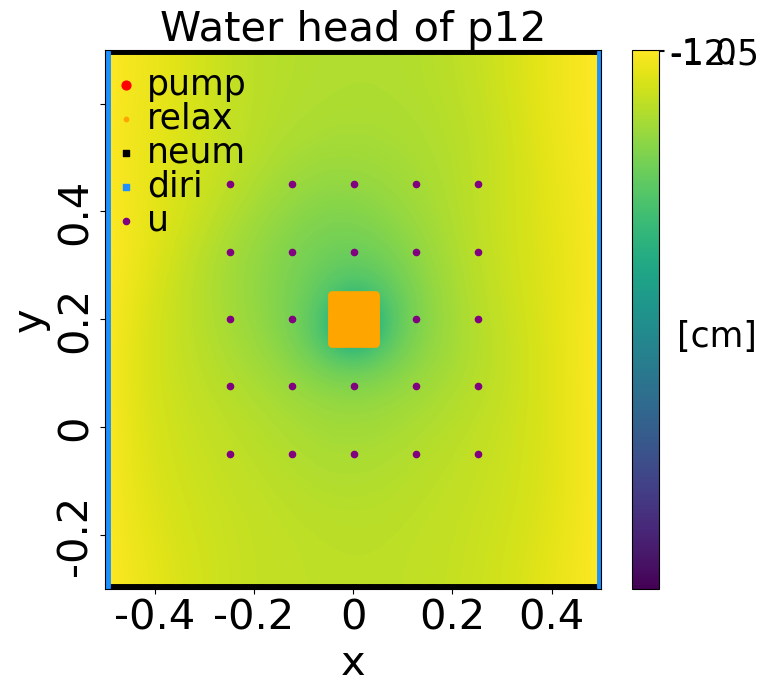

In [12]:
#################### set font size ####################
axis_label_font_size = 30
axis_tick_font_size = 30
legend_fontszie = 25
colorbar_font_size = 25
title_size = 30

################ show logK field ###################
fig2,ax2 = plt.subplots(figsize=(7,6))

im2 = ax2.pcolor(X,Y,logK, cmap='jet')
ax2.set_xlabel('x')
ax2.set_ylabel('y')
fig2.colorbar(im2, ax=ax2, orientation='vertical')
ax2.scatter(X_star[K_measure_id,0], X_star[K_measure_id,1], marker='v', zorder=1, alpha= 1, c='m', s=30)
ax2.set_title("lnK field",fontsize=title_size)

################ show water heads under a pumping event (pe) ###################
pe = 12
head = heads[:,pe].reshape((nx,ny))

fig, ax = plt.subplots(1, 1, figsize=(8,7))
im = ax.pcolor(X,Y,head)

ax.scatter(X_star[pump_cell_idx[pe],0], X_star[pump_cell_idx[pe],1], marker="o", zorder=1, alpha= 1, c='r', s=40, label="pump")
ax.scatter(X_star[around_idx[pe],0], X_star[around_idx[pe],1], zorder=1, alpha= 1.0, c='orange', s=10, label="relax")
ax.scatter(X_star[ybound_idx,0], X_star[ybound_idx,1], marker='s', zorder=1, alpha= 1, c='k', s=20, label="neum")
ax.scatter(X_star[xbound_idx,0], X_star[xbound_idx,1], marker='s', zorder=1, alpha= 1, c='dodgerblue', s=20, label="diri")
ax.scatter(X_star[np.delete(pump_cell_idx,pe),0], X_star[np.delete(pump_cell_idx,pe),1], zorder=1, alpha= 1, c='purple', s=20, label="u")

ax.set_xlabel('x',fontsize=axis_label_font_size)
ax.set_ylabel('y',fontsize=axis_label_font_size)
labels = [-0.4, -0.2, 0, 0.2, 0.4]
ax.set_xticks(labels)
ax.set_xticks(labels)
ax.set_xticklabels(labels,fontsize=axis_tick_font_size,ha='center')
ax.set_yticklabels(labels,fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')

ax.legend(loc='upper left',ncol=1,prop={'size': legend_fontszie}, framealpha=0, facecolor='none',borderpad=0.01,labelspacing=0.001,handletextpad=0.5, handlelength=0.2,columnspacing=0.02)

cbar = fig.colorbar(im, ax=ax,ticks=[-0.125, -0.010])
cbar.ax.set_ylabel('[cm]',labelpad=-30,rotation=0,va='top',size=25)
cbar.ax.set_yticklabels(['-12.5', '-1.0']) 
cbar.ax.tick_params(labelsize=colorbar_font_size) 
ax.set_title('Water head of p'+str(pe),fontsize=title_size)

# Initialize model

In [13]:
############# create PINN instance #############

hnu = 50 # number of hidden unit in each layer of net u
hnK = 50 # number of hidden unit in each layer of net K

layers = [2, hnu, hnu, hnu, hnu, hnu, hnu, 1]
layers_K = [2, hnK, hnK, hnK, hnK, hnK, hnK, 1]

model =PhysicsInformedNN(layers,layers_K)

# Prepare data batch

In [14]:
############# fixed data used for all nets ##########

############# K measurements ##########
K_star = K.flatten()[:,None]
K_train = K_star[K_measure_id]
X_K_train = X_star[K_measure_id]

# Domain bounds   
lbs = np.array([min(x),min(y)])
ubs = np.array([max(x),max(y)])
    
################### Dirichlet BCs (left & right bound)  ##########
N_diri = 64 # No. of point for Dirichlet BCs
# left (x=0) and right (x=1)
xx = X_star[xbound_idx]
uu = np.zeros((xx.shape[0],1))

X_diri_train = xx
diri_train = uu

################### Neumann BCs (top & bottom bound)  #############
N_neum = 64  # No. of points for Neumann BCs
# bottom (y = 0) and top (y=1)
yy = X_star[ybound_idx]
du = np.zeros((yy.shape[0],1))

X_neum_train = yy
neum_train = du

# transform data for network training
neum_data = model.data_loader(X_neum_train, neum_train, lbs, ubs)
diri_data = model.data_loader(X_diri_train, diri_train, lbs, ubs)
K_data = model.data_loader(X_K_train, K_train, lbs, ubs)

In [15]:
############# specific data in each individual pumping events ##########

Qp = 30             # approximated water amount changing rate in pumping grid

n_batches = 10      # number of batches
Nf = 900            # number of collocated grids in each batch
data_batch = []     # one batch of training data
data_batches = []   # container of batches

for db in range(n_batches):
  data_batch = []
  for jj in range(num_wells):

    # pump well and pump rate 
    X_pump_train = X_star[pump_cell_idx[jj]][None,:]
    pump_train = np.array([[Qp]])

    # water heads at monitor wells
    u_star = heads[:,jj][:,None]
    X_u_train = X_star[np.delete(pump_cell_idx,jj)]
    u_train = u_star[np.delete(pump_cell_idx,jj)]

    # add noise to data and normalize
    u_train = u_train + np.random.normal(0,np.abs(0.05*u_train),u_train.shape)
    u_train_norm = np.linalg.norm(u_train)
    u_train = u_train/u_train_norm

    # cells outside pump (relax) region set for PDE constraints
    region_idx = np.hstack((pump_cell_idx[jj],around_idx[jj],xbound_idx,ybound_idx))
    X_f_space = np.delete(X_star, region_idx, 0)

    collocate_id = np.random.randint(0, X_f_space.shape[0], Nf)

    # collocate_id_mat[db,jj,:] = collocate_id
    X_f_train = X_f_space[collocate_id]
    f_train = np.zeros((X_f_train.shape[0],1))

    # transform data for network training
    f_data = model.data_loader(X_f_train, f_train, lbs, ubs)
    u_data = model.data_loader(X_u_train, u_train, lbs, ubs)
    pump_data = model.data_loader(X_pump_train, pump_train, lbs, ubs)

    # Assemble data batch containing training data
    # training data is in dict format: key: name -> value: (x,y,val)
    train_dict = {
      'neum': neum_data,
      'diri': diri_data,
      'u': u_data,
      'f': f_data,
      'K': K_data,
      'pump': pump_data
    }

    data_batch.append(train_dict)
  data_batches.append(data_batch)

# Choose simulated pumping wells

In [16]:
# select pumping events for forward models
pump_id_list = [0, 4, 12, 20, 24]

npump = len(pump_id_list)

# Training configurations
## save for future reproduce

In [17]:
# hyper-parameters setup

# loss type aggregated in total loss
pred_ks = ['diri', 'neum', 'u', 'pump','f','K']

loss_weights = {
  'f': 50.0,
  'u': 10000.0,
  'neum': 10000.0,
  'pump': 1.0,
  'K': 1000.0,
  'diri': 20000.0
}

# networks weights to tune
for pid in pump_id_list:
  model.weights += model.forward_models[pid].parameters()
model.weights += model.inverse_model.parameters()

# print out loss by interval = p_intervals
p_intervals = 100

In [18]:
# save hyper-parameters
hyper_param = copy.copy(loss_weights)
hyper_param['epoch'] = [0]
hyper_param['lr'] = []
hyper_param['Qp'] = Qp
hyper_param['r'] = r
hyper_param['hnK'] = hnK
hyper_param['hnu'] = hnu
hyper_param['lenK'] = len(layers_K)
hyper_param['lenu'] = len(layers)
hyper_param['act_K'] = 'tanh'
hyper_param['act_u'] = 'tanh'
hyper_param['out_K'] = 'linear'
hyper_param['out_u'] = 'linear'


# Training loop

In [19]:
# training process

# define optimizer
optimizer = torch.optim.Adam(params=model.weights, lr=1e-3)

num_epoch = 500
iter = 1

start_time = time.time()

for epoch in range(num_epoch):
  for batch_id in range(n_batches):
    data_batch = data_batches[batch_id]
    model.train(iter, data_batch, model.loss_func, optimizer, pred_ks, loss_weights, pump_id_list, p_intervals)

  if epoch%p_intervals==0 or epoch==num_epoch-1:
    elapsed = time.time() - start_time
    print('Epoch#: %d, Iter#: %d, Loss: %.4f, Time: %.4f' % (epoch, len(model.loss_list), model.loss_list[-1], elapsed))
    print_loss = dict()
    for pid in pump_id_list:
      print_loss = "Pump "+ str(pid) + ": "
      for k in pred_ks:
        s = k+":"+str(model.loss_container[pid][k][-1])+"; "
        print_loss += s
      print(print_loss)

elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))


Epoch#: 0, Iter#: 10, Loss: 8231.6348, Time: 1.4674
Pump 0: diri:80.30842989683151; neum:4.735171678476036; u:199.603121727705; pump:898.6526489257812; f:0.01287735503865406; K:445.10483741760254; 
Pump 4: diri:240.07929489016533; neum:4.282885347492993; u:110.13374663889408; pump:898.0762329101562; f:0.025387346977367997; K:445.10483741760254; 
Pump 12: diri:80.43970912694931; neum:0.2145714097423479; u:202.35111936926842; pump:899.5932006835938; f:0.002004482303163968; K:445.10483741760254; 
Pump 20: diri:90.93445725739002; neum:1.8149476090911776; u:204.23807203769684; pump:899.1795043945312; f:0.005369718564907089; K:445.10483741760254; 
Pump 24: diri:101.06338188052177; neum:4.726512124761939; u:186.85203045606613; pump:898.7732543945312; f:0.013171795581001788; K:445.10483741760254; 


KeyboardInterrupt: 

In [ ]:
# tune learn rate down

# define optimizer
optimizer = torch.optim.Adam(params=model.weights, lr=1e-4)

num_epoch = 1500
iter = 1

start_time = time.time()

for epoch in range(num_epoch):
  for batch_id in range(n_batches):
    data_batch = data_batches[batch_id]
    model.train(iter, data_batch, model.loss_func, optimizer, pred_ks, loss_weights, pump_id_list, p_intervals)

  if epoch%p_intervals==0 or epoch==num_epoch-1:
    elapsed = time.time() - start_time
    print('Epoch#: %d, Iter#: %d, Loss: %.4f, Time: %.4f' % (epoch, len(model.loss_list), model.loss_list[-1], elapsed))
    print_loss = dict()
    for pid in pump_id_list:
      print_loss = "Pump "+ str(pid) + ": "
      for k in pred_ks:
        s = k+":"+str(model.loss_container[pid][k][-1])+"; "
        print_loss += s
      print(print_loss)

elapsed = time.time() - start_time
print('Training time: %.4f' % (elapsed))


# Model evaluation

In [ ]:
X_pred= model.coor_shift(X_star, lbs, ubs)
error_u_list = []
for ti in pump_id_list:

  u_true = heads[:,ti]
  u_pred = model.predict(X_pred, pid=ti, target='u')
  u_train = u_true[np.delete(pump_cell_idx,ti)]
  u_train_norm = np.linalg.norm(u_train)
  u_pred = u_pred*u_train_norm

  u_err = u_pred-u_true
  error_u = np.linalg.norm(u_err,2)/np.linalg.norm(u_true,2)
  error_u_list.append(error_u)

print(error_u_list)
print("Min Err: ", min(error_u_list))
print("Max Err: ", max(error_u_list))
print("mean Err: ", np.mean(error_u_list))
print("std Err: ", np.std(error_u_list))

In [ ]:
#set font size
axis_label_font_size = 28
axis_tick_font_size = 30
legend_fontszie = 25
colorbar_font_size = 30
title_size = 30

ti = pump_id_list[-2]
X_pred= model.coor_shift(X_star, lbs, ubs)
u_true = heads[:,ti]

u_pred = model.predict(X_pred, pid=ti, target='u')
u_train = u_true[np.delete(pump_cell_idx,ti)]
u_train_norm = np.linalg.norm(u_train)
u_pred = u_pred*u_train_norm

u_err = u_pred-u_true
error_u = np.linalg.norm(u_err,2)/np.linalg.norm(u_true,2)
print('Relative Residual of forward problem: %.4f' % (error_u))

u_pred = u_pred.reshape((nx,ny))
u_true = u_true.reshape((nx,ny))

################### hydraulic head plot: colormap and contour ##################

scaler_min = np.min(u_pred)*0.95
scaler_max = np.max(u_pred)*0.95
scaler_len = scaler_max - scaler_min

#set font size
axis_label_font_size = 28
axis_tick_font_size = 30
legend_fontszie = 25
colorbar_font_size = 30
title_size = 30

fig_forward_2, axs = plt.subplots(1,2,figsize=(12,5.6),frameon=False, sharex=False,sharey=False)

scaler_min = np.min(u_pred)*0.95
scaler_max = np.max(u_pred)*0.95
scaler_len = scaler_max - scaler_min

lvls = np.linspace(scaler_min,scaler_max,7)

ax = axs[0]
im = ax.pcolormesh(X, Y, u_true, vmin=scaler_min, vmax=scaler_max)

CT = ax.contour(X, Y, u_true, levels=lvls,cmap="coolwarm")
ax.clabel(CT,fontsize=15,inline=True,inline_spacing=1,fmt='%.1f')

ax.set_xlabel('x',fontsize=axis_label_font_size)
ax.set_ylabel('y',fontsize=axis_label_font_size)

ticks = [-0.4, 0.0, 0.4]

labels = [0.1, 0.5, 0.9]
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(labels,Fontsize=axis_tick_font_size,ha='center')
ax.set_yticklabels(labels,Fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')
ax.set_title('(A). True Water Heads',fontsize=title_size)

ax = axs[1]
im = ax.pcolormesh(X, Y, u_pred, vmin=scaler_min, vmax=scaler_max)
CP = ax.contour(X, Y, u_pred,levels=lvls,cmap="coolwarm")
ax.clabel(CP,fontsize=15,inline=True,fmt='%.1f')
ax.set_xlabel('x',fontsize=axis_label_font_size)

ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(labels,Fontsize=axis_tick_font_size,ha='center')
ax.set_yticklabels(labels,Fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')
ax.set_title('(B). Prediction from $NN^{%d}$' % (ti+1), fontsize=title_size)



In [ ]:
################### hydraulic conductivity colormap plot: 2D ##################
K_pred = model.predict(X_pred, pid=ti, target='K')
# K_pred = K_pred*K_train_norm
K_true = K.flatten()

K_err = K_true - K_pred
error_K = np.linalg.norm(K_err,2)/np.linalg.norm(K_true,2)
print("Relative Residual: %.4f" % error_K)
K_pred = K_pred.reshape((nx,ny))

minlK, maxlK = np.min(logK), np.max(logK)


fig,ax = plt.subplots(figsize=(7,6))
im = ax.pcolormesh(X,Y,logK,cmap='jet')
im.set_clim(minlK, maxlK )
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(labels,Fontsize=axis_tick_font_size,ha='center')
ax.set_yticklabels(labels,Fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')
ax.set_title('(A). Reference $lnT$ field',fontsize=title_size)

logK_pred = np.nan_to_num(np.log(K_pred),nan=minlK)
fig,ax = plt.subplots(figsize=(7,6))
im = ax.pcolormesh(X,Y, logK_pred,cmap='jet')
im.set_clim(minlK, maxlK)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(labels,Fontsize=axis_tick_font_size,ha='center')
ax.set_yticklabels(labels,Fontsize=axis_tick_font_size,rotation=90, ha='right', va='center')
ax.set_title('(B). Estimation from $TNN$',fontsize=title_size)


# threshold 10%
thres = 0.1
K_len = maxlK-minlK

# acc = np.divide(abs(logK-K_pred),abs(K))
acc = abs(logK-logK_pred)/K_len


print("Accuracy with 10%% threshold: %.4f" % (sum(sum(acc<thres))/(nx*ny)))

# Save model

In [ ]:
# model_dir = "./model_coeff/"

# if not os.path.isdir(model_dir):
#   os.makedirs(model_dir)

# torch.save(model.inverse_model, model_dir+"/inverse.pth")

# for fid in pump_id_list: 
#   forward_net = model.forward_models[fid]
#   torch.save(forward_net, model_dir+"/forward_"+str(fid)+".pth")

# ############## save hyper-parameters for reproduce ##################
# with open( model_dir+"/hyper_param.txt","w") as f:
#   f.write(str(hyper_param))


# Load model

In [ ]:
# model = PhysicsInformedNN(layers,layers_K)

# load_dir = "./model_coeff/"

# model.inverse_model = torch.load(load_dir+"/inverse.pth")
# for fid in pump_id_list:
#   model.forward_models[fid] = torch.load(load_dir+"/forward_"+str(fid)+".pth")

# with open(load_dir+"/hyper_param.txt","r") as file:
#   line = file.read()
#   loaded_hyper_param = ast.literal_eval(line)
# print(loaded_hyper_param)
